## Introdução

O objetivo deste notebook é executar o K-Means clustering para ver se o algoritmo consegue agrupar com sucesso as notícias em 'Reais' e 'Falsas' usando apenas as palavras dos artigos.

## Imports

In [18]:
import numpy as np # álgebra Linear
import pandas as pd # processamento de dados, E/S de arquivo CSV (por exemplo, pd.read_csv)

import matplotlib.pyplot as plt # plotagem e visualização de dados
import seaborn as sns # melhorar o visual
sns.set() # Definir como estilo padrão

import string #biblioteca python
import re #biblioteca regex

from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short # Preprocesssing
from gensim.models import Word2Vec # Word2vec
from sklearn.metrics import confusion_matrix # Matriz de confusão

from sklearn import cluster # Kmeans clustering
from sklearn import metrics # Métricas para avaliação
from sklearn.decomposition import PCA #PCA
from sklearn.manifold import TSNE #TSNE

### Criando a função para gerar a matrix de confusão

In [19]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

## Análise e limpeza de dados

In [20]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [21]:
fake.head(10)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017"
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017"
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017"
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017"
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017"


In [22]:
true.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017"


In [23]:
# Mesclando título e texto
fake['Sentences'] = fake['title'] + ' ' + fake['text']
true['Sentences'] = true['title'] + ' ' + true['text']

# Adicionando rótulo falso e verdadeiro
fake['Label'] = 0
true['Label'] = 1

# Podemos mesclar os dois, pois agora temos os rótulos
final_data = pd.concat([fake, true])

# Randomize as linhas para que tudo fique misturado
final_data = final_data.sample(frac=1).reset_index(drop=True)

# Eliminar colunas não é necessário
final_data = final_data.drop(['title', 'text', 'subject', 'date'], axis = 1)

final_data.head(10)

,Sentences,Label
0,Libyan forces suffer casualties as fighting dr...,1
1,Iraqi Shi’ite militias accused of rights abuse...,1
2,TRUMP SUPPORTER Whose Brutal Beating By Black ...,0
3,Trump close to picking outside counsel for Rus...,1
4,Risk of deeper involvement as U.S. weighs its ...,1
5,U.S. slams proposed Israeli bill on settlement...,1
6,Christian School Principal Arrested For Horri...,0
7,Kremlin accuses West of 'whipping up hysteria'...,1
8,Trump ignites political fight over U.S. bankin...,1
9,Bulgaria parliament passes anti-corruption law...,1


### Function to process the texts

In [24]:
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

In [25]:
processed_data = final_data["Sentences"]
processed_labels = final_data["Label"]
processed_data = processed_data.apply(wordopt)

## Word2Vec

In [26]:
# Modelo Word2Vec treinado em dados processados
model = Word2Vec(processed_data, min_count=1)

## Vetores de frases

In [27]:
# Obtendo o vetor de uma frase com base na média de todos os vetores de palavras na frase
# Obtemos a média, pois isso leva em conta diferentes comprimentos de frase

def ReturnVector(x):
    try:
        return model[x]
    except:
        return np.zeros(100)
    
def Sentence_Vector(sentence):
    word_vectors = list(map(lambda x: ReturnVector(x), sentence))
    return np.average(word_vectors, axis=0).tolist()

X = []
for data_x in processed_data:
    X.append(Sentence_Vector(data_x))

In [28]:
X_np = np.array(X)
X_np.shape

(44898, 100)

## Agrupamento/Clustering

In [29]:
# Treinamento para 2 clusters (Falso e Real)
kmeans = cluster.KMeans(n_clusters=2, verbose=1)

# Fit Predict retornará rótulos
clustered = kmeans.fit_predict(X_np)

/home/idc-evo/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 0.0.
Converged at iteration 0: center shift 0.0 within tolerance 0.0.
Initialization complete
Iteration 0, inertia 0.0.
Converged at iteration 0: center shift 0.0 within tolerance 0.0.
Initialization complete
Iteration 0, inertia 0.0.
Converged at iteration 0: center shift 0.0 within tolerance 0.0.
Initialization complete
Iteration 0, inertia 0.0.
Converged at iteration 0: center shift 0.0 within tolerance 0.0.
Initialization complete
Iteration 0, inertia 0.0.
Converged at iteration 0: center shift 0.0 within tolerance 0.0.
Initialization complete
Iteration 0, inertia 0.0.
Converged at iteration 0: center shift 0.0 within tolerance 0.0.
Initialization complete
Iteration 0, inertia 0.0.
Converged at iteration 0: center shift 0.0 within tolerance 0.0.
Initialization complete
Iteration 0, inertia 0.0.
Converged at iteration 0: center shift 0.0 within tolerance 0.0.
Initialization complete
Iteration 0, inertia 0.0.
Converged at iteration 0: cent

/home/idc-evo/.local/lib/python3.10/site-packages/sklearn/base.py:1151: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


In [30]:
testing_df = {'Sentence': processed_data, 'Labels': processed_labels, 'Prediction': clustered}
testing_df = pd.DataFrame(data=testing_df)

testing_df.head(10)

,Sentence,Labels,Prediction
0,libyan forces suffer casualties as fighting dr...,1,0
1,iraqi shi ite militias accused of rights abuse...,1,0
2,trump supporter whose brutal beating by black ...,0,0
3,trump close to picking outside counsel for rus...,1,0
4,risk of deeper involvement as u s weighs its ...,1,0
5,u s slams proposed israeli bill on settlement...,1,0
6,christian school principal arrested for horri...,0,0
7,kremlin accuses west of whipping up hysteria ...,1,0
8,trump ignites political fight over u s bankin...,1,0
9,bulgaria parliament passes anti corruption law...,1,0


Os resultados acima mostram que eles foram agrupados corretamente em alguns casos onde 0 é notícia falsa e 1 é notícia real

In [31]:
correct = 0
incorrect = 0
for index, row in testing_df.iterrows():
    if row['Labels'] == row['Prediction']:
        correct += 1
    else:
        incorrect += 1
        
print("Correctly clustered news: " + str((correct*100)/(correct+incorrect)) + "%")

Correctly clustered news: 52.29854336496058%


### Confusion Matrix

/tmp/ipykernel_92502/1278401157.py:65: RuntimeWarning: invalid value encountered in scalar divide
  precision = cf[1,1] / sum(cf[:,1])


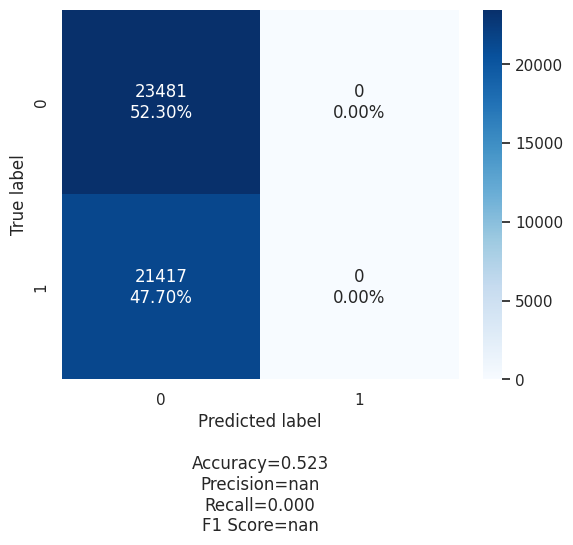

In [32]:
cm = confusion_matrix(processed_labels, clustered)
make_confusion_matrix(cf= cm)

## Testes de notícias personalizados

In [33]:
# Teste com notícias falsas geradas em https://www.thefakenewsgenerator.com/
onion_data = "Flint Residents Learn To Harness Superpowers, But Trump Gets Away Again They developed superpowers after years of drinking from a lead-poisoned water supply. But just having incredible abilities doesn't make them superheroes. Not yet. Donald Trump faced off against the superpowered civilians but he got away before they could catch him"

# Artigo de pré-processamento
onion_data = wordopt(onion_data)

# Obtém vetor de frase
onion_data = Sentence_Vector(onion_data)

# Obtém a previsão
kmeans.predict(np.array([onion_data]))

array([0], dtype=int32)

In [34]:
# Notícias da BBC

bbc_data = "Nasa Mars 2020 Mission's MiMi Aung on women in space Next year, Nasa will send a mission to Mars. The woman in charge of making the helicopter that will be sent there – which is set to become the first aircraft to fly on another planet – is MiMi Aung. At 16, MiMi travelled alone from Myanmar to the US for access to education. She is now one of the lead engineers at Nasa. We find out what it's like being a woman in space exploration, and why her mum is her biggest inspiration."

# pré-processamento do artigo
bbc_data = wordopt(bbc_data)

# Obter vetor de sentença
bbc_data = Sentence_Vector(bbc_data)

# Obtém a previsão
kmeans.predict(np.array([bbc_data]))

array([0], dtype=int32)